# Support Vector Machines
---

__This Notebook__

- I learn about the various hyperparameters of the `sklearn.svm.SVC` class for C-Support Vector Classification. 
- I did not implement a robust cross-validation and grid search scheme since there are too many parameters to learn
- I did play a bit with thresholds to learn how the predict methods work

__Results__ 

- In retrospect, I should've read the docs first (big surprise) and implemented __GridSearchCV__ with `C` and `gamma` spaced exponentially far apart to choose good values

## Setup

In [86]:
import re
import os
import time
import joblib 

import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.metrics import confusion_matrix


dt_object = datetime.fromtimestamp(time.time())
day, T = str(dt_object).split('.')[0].split(' ')
print('Revised on: ' + day)

Revised on: 2021-01-23


## Load

In [87]:
# load target vector
raw_path = os.path.join("data","1_raw")
y_df = pd.read_csv(os.path.join(raw_path, 'y_train.csv'))
y_array = np.array(y_df.iloc[:,0].ravel())

y = y_array.copy()

# transform y_array into int type
y[y=='ham'] = 0
y[y=='spam'] = 1
y = y.astype('int')

In [88]:
# load matrices
proc_dir = os.path.join("data", "2_processed")
X_tfidf_svd800_spamcos = sp.load_npz(os.path.join(proc_dir, 'X_tfidf_svd800_spamcos.npz'))
X_tfidf_svd800_spamcos_scaled = sp.load_npz(os.path.join(proc_dir, 'X_tfidf_svd800_spamcos_scaled.npz'))

__Ranges__

We see that the unscaled is actually more compact around 0, whereas the scaled has a nice -1 to 1 range.

In [89]:
X = X_tfidf_svd800_spamcos.todense()
np.amin(X), np.amax(X)

(-0.13501015228690652, 0.15613997096670862)

In [90]:
X = X_tfidf_svd800_spamcos_scaled.todense()
np.amin(X), np.amax(X)

(-1.0, 1.0)

## Helpful Functions


In [91]:
# train classifier and time it
def time_deco(func):
    def wrapper(clf):
        start = time.time()
        func(clf)
        m,s = divmod(time.time() - start, 60)
        print(f'Elapsed: {m:0.0f}m {s:0.0f}s')
    return wrapper

@time_deco
def fit_clf(clf):
    clf.fit(X_train, y_train)
    
# evaluate classifier
def eval_clf(y_val, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_val, 
                                      y_pred).ravel()
    confmat_df = pd.DataFrame(
        np.array(([tn, fp], [fn, tp])),
        columns=['pred_neg', 'pred_pos'], 
        index=['cond_neg', 'cond_pos']
    )
    # unpack metrics
    acc = (tp + tn) / (tp + tn + fp + fn)
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    # print results
    print(confmat_df)
    print(f'acc: {acc:0.4f}')
    print(f'tpr: {tpr:0.4f}')
    print(f'tnr: {tnr:0.4f}')

## Unscaled

### Train Test Split

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X_train, X_val, y_train, y_val = train_test_split(X_tfidf_svd800_spamcos,
                                                  y, 
                                                  stratify=y,
                                                  random_state=42)

##  SVC (Support Vector Classifier) 

[See docs](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

__Some defaults:__
- `C=1.0`: no regularization
- `kernel='rbf'`: radial basis function kernel
- `degree=3`: polynomial degree, ignored for kernels other than `poly`; also try `sigmoid` or `precomputed`?
- `gamma='scale'`: coefficient for `rbf`, `poly` and `sigmoid`
- `coef0=0.0`: independent term in kernel function. It is only significant in `poly` and `sigmoid`
- `shrinking=True`: whether to use the shrinking heuristic. 
- `probability=False`: whether to enable probability estimates. This must be enabled prior to calling fit, will slow down that method as it internally uses 5-fold cross-validation, and `predict_proba` may be inconsistent with `predict`
- `class_weight=None`: pass a dict or 'balanced' 

__Some methods:__

- `.get_params`: returns the parameters
- `.decision_function`: evaluates the decision function for the samples in X, if binary from -1 to 1
- `.predict`: performs the classification, equivalent to decision_function with a 0 threshold
- `.predict_proba`: compute probabilities of possible outcomes for samples in X. The model need to have probability information computed at training time (i.e., fit with `probability=True`)


### RBF kernel `C` and `gamma`:

[See Docs](https://scikit-learn.org/stable/modules/svm.html#svm-kernels)

When training an SVM with the Radial Basis Function (RBF) kernel, two parameters must be considered: $C$ and $\gamma$. 

$C$: common to all SVM kernels, trades off misclassification of training examples against simplicity of the decision surface. A low $C$ makes the decision surface smooth, while a high $C$ aims at classifying all training examples correctly. 

$\gamma$: defines how much influence a single training example has. The larger $\gamma$ is, the closer other examples must be to be affected.

In [93]:
# instantiate
svm_clf = SVC(random_state=42)

In [94]:
# train
fit_clf(svm_clf)

Elapsed: 0m 19s


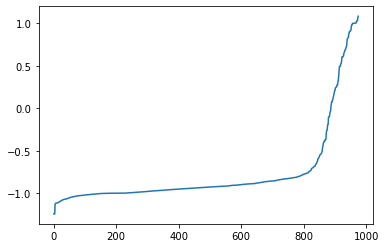

In [97]:
# evaluate using decision function
y_score = svm_clf.decision_function(X_val)
plt.plot(sorted(y_score))
plt.show()

Predicting with `threshold=0` is equivalent to using the `.predict` method

In [98]:
# default threshold
thresh = 0
y_pred = np.where(y_score > thresh, 1, 0)
eval_clf(y_val, y_pred)

          pred_neg  pred_pos
cond_neg       846         0
cond_pos        41        88
acc: 0.9579
tpr: 0.6822
tnr: 1.0000


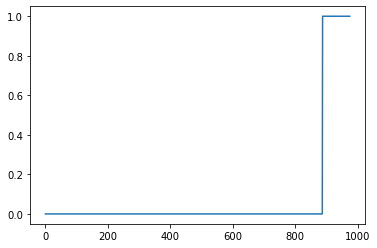

In [99]:
y_pred = svm_clf.predict(X_val)
plt.plot(sorted(y_pred))
plt.show()

In [100]:
eval_clf(y_val, y_pred)

          pred_neg  pred_pos
cond_neg       846         0
cond_pos        41        88
acc: 0.9579
tpr: 0.6822
tnr: 1.0000


Lowering the threshold increases sensitivity - as expected since we get more positives in the mix.

In [105]:
# lower threshold
thresh = -.5
y_pred = np.where(y_score > thresh, 1, 0)
eval_clf(y_val, y_pred)

          pred_neg  pred_pos
cond_neg       842         4
cond_pos        18       111
acc: 0.9774
tpr: 0.8605
tnr: 0.9953


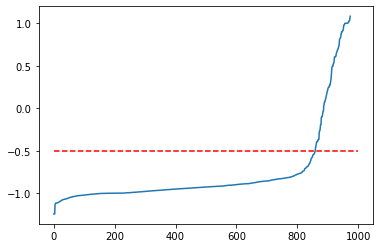

In [111]:
plt.plot(sorted(y_score))
plt.hlines(thresh, 0, 1000, colors='r', linestyles='dashed')
plt.show()

In [113]:
# even lower threshold
thresh = -.7
y_pred = np.where(y_score > thresh, 1, 0)
eval_clf(y_val, y_pred)

          pred_neg  pred_pos
cond_neg       821        25
cond_pos         8       121
acc: 0.9662
tpr: 0.9380
tnr: 0.9704


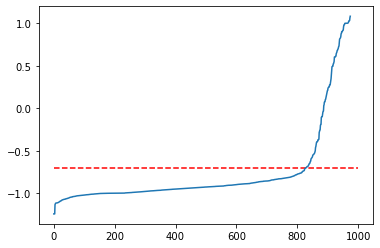

In [114]:
plt.plot(sorted(y_score))
plt.hlines(thresh, 0, 1000, colors='r', linestyles='dashed')
plt.show()

The `.predict_proba` method doesn't work, as expected:

In [115]:
try:
    y_pred = svm_clf.predict_proba(X_val)
except AttributeError as e:
    print(e)

predict_proba is not available when  probability=False


### `Probability=True`

In [117]:
# instantiate
svm_clf_prob = SVC(random_state=42, probability=True)

In [118]:
# training takes longer because of 5-fold CV
fit_clf(svm_clf_prob)

Elapsed: 1m 36s


-  `.decision_function` or `.predict` yield same results as `probability=False` so the benefit lies in using the probabilities

In [119]:
y_prob = svm_clf_prob.predict_proba(X_val)
y_pred = svm_clf_prob.predict(X_val)

In [120]:
np.set_printoptions(precision=3, suppress=True) 

# i.e. first ten predictions
y_prob[:10], y_pred[:10]

(array([[0.991, 0.009],
        [0.988, 0.012],
        [0.996, 0.004],
        [0.   , 1.   ],
        [0.992, 0.008],
        [0.989, 0.011],
        [0.   , 1.   ],
        [0.989, 0.011],
        [0.993, 0.007],
        [0.   , 1.   ]]),
 array([0, 0, 0, 1, 0, 0, 1, 0, 0, 1]))

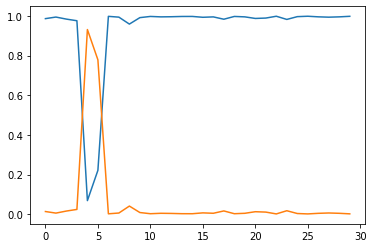

In [121]:
plt.plot(y_prob[40:70,0]) # blue, zeroes (ham)
plt.plot(y_prob[40:70,1]) # orange, ones (spam)
plt.show()

Probabilities are often extreme, either way they are complementary.

This plot is slightly confusing in that 0/1 = low/high probs for either ham or spam, blue is ham, orange is spam.

In [140]:
# default threshold (,1 = spam)
thresh = .5
y_pred = np.where(y_prob[:,1] > thresh, 1, 0)
print_metrics(y_val, y_pred)

          pred_neg  pred_pos
cond_neg       842         4
cond_pos        18       111
acc: 0.9774
tpr: 0.8605
tnr: 0.9953


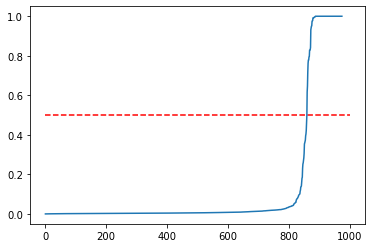

In [141]:
plt.plot(sorted(y_prob[:,1])) # spam
plt.hlines(thresh, 0, 1000, colors='r', linestyles='dashed')
plt.show()

In [149]:
# lower threshold to detect spam
thresh = 0.1
y_pred = np.where(y_prob[:,1] > thresh, 1, 0)
print_metrics(y_val, y_pred)

          pred_neg  pred_pos
cond_neg       827        19
cond_pos         9       120
acc: 0.9713
tpr: 0.9302
tnr: 0.9775


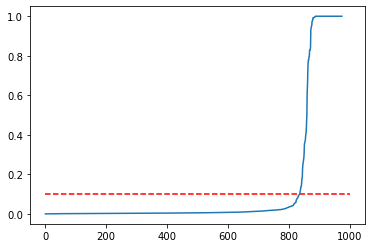

In [150]:
plt.plot(sorted(y_prob[:,1])) # spam
plt.hlines(thresh, 0, 1000, colors='r', linestyles='dashed')
plt.show()

## Scaled

### Train Test Split

In [152]:
X_train, X_val, y_train, y_val = train_test_split(X_tfidf_svd800_spamcos_scaled,
                                                  y, 
                                                  stratify=y,
                                                  random_state=42)

In [153]:
# instantiate
svm_clf = SVC(random_state=42)

In [154]:
# train
fit_clf(svm_clf)

Elapsed: 0m 19s


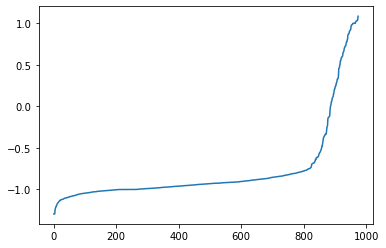

In [155]:
# evaluate using decision function
y_score = svm_clf.decision_function(X_val)
plt.plot(sorted(y_score))
plt.show()

In [156]:
# default threshold
# results are very similar to unscaled, one more TN
thresh = 0
y_pred = np.where(y_score > thresh, 1, 0)
eval_clf(y_val, y_pred)

          pred_neg  pred_pos
cond_neg       846         0
cond_pos        40        89
acc: 0.9590
tpr: 0.6899
tnr: 1.0000


In [157]:
# even lower threshold
# also very similar, three more TP
thresh = -.7
y_pred = np.where(y_score > thresh, 1, 0)
eval_clf(y_val, y_pred)

          pred_neg  pred_pos
cond_neg       818        28
cond_pos         8       121
acc: 0.9631
tpr: 0.9380
tnr: 0.9669


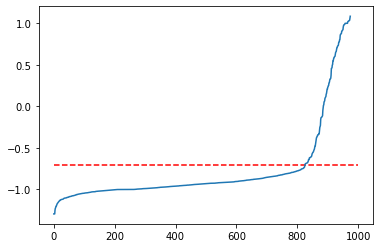

In [158]:
plt.plot(sorted(y_score))
plt.hlines(thresh, 0, 1000, colors='r', linestyles='dashed')
plt.show()

### `Probability=True`

In [159]:
# instantiate
svm_clf_prob = SVC(random_state=42, probability=True)

In [160]:
fit_clf(svm_clf_prob)

Elapsed: 1m 34s


In [161]:
y_prob = svm_clf_prob.predict_proba(X_val)

In [162]:
# default
thresh = .5
y_pred = np.where(y_prob[:,1] > thresh, 1, 0)
print_metrics(y_val, y_pred)

          pred_neg  pred_pos
cond_neg       841         5
cond_pos        17       112
acc: 0.9774
tpr: 0.8682
tnr: 0.9941


In [163]:
# lower threshold to detect spam
thresh = 0.1
y_pred = np.where(y_prob[:,1] > thresh, 1, 0)
print_metrics(y_val, y_pred)

          pred_neg  pred_pos
cond_neg       827        19
cond_pos         8       121
acc: 0.9723
tpr: 0.9380
tnr: 0.9775


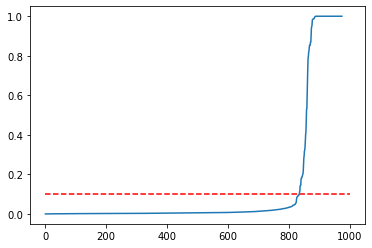

In [164]:
plt.plot(sorted(y_prob[:,1])) # spam
plt.hlines(thresh, 0, 1000, colors='r', linestyles='dashed')
plt.show()

Results are very similar but the scaled version does seem to perform a tad better.

### Adjusting the class weight according to the data

- Alternatively, we could pass `class_weight={0:1, 1:7}` to balance out the classes

In [165]:
svm_clf_prob_bal = SVC(
    random_state=42
    , probability=True
    , class_weight='balanced'
)

In [166]:
fit_clf(svm_clf_prob_bal)

Elapsed: 1m 33s


In [167]:
y_prob = svm_clf_prob_bal.predict_proba(X_val)

In [168]:
# default
thresh = .5
y_pred = np.where(y_prob[:,1] > thresh, 1, 0)
print_metrics(y_val, y_pred)

          pred_neg  pred_pos
cond_neg       841         5
cond_pos        17       112
acc: 0.9774
tpr: 0.8682
tnr: 0.9941


In [171]:
# lower
thresh = .1
y_pred = np.where(y_prob[:,1] > thresh, 1, 0)
print_metrics(y_val, y_pred)

          pred_neg  pred_pos
cond_neg       822        24
cond_pos        10       119
acc: 0.9651
tpr: 0.9225
tnr: 0.9716


In [172]:
svm_clf_prob_bal = SVC(
    random_state=42
    , probability=True
    , class_weight={0:1, 
                    1:7} # seven times more spam to balance out
)

In [173]:
fit_clf(svm_clf_prob_bal)

Elapsed: 1m 35s


In [174]:
y_prob = svm_clf_prob_bal.predict_proba(X_val)

In [175]:
# default
thresh = .5
y_pred = np.where(y_prob[:,1] > thresh, 1, 0)
print_metrics(y_val, y_pred)

          pred_neg  pred_pos
cond_neg       842         4
cond_pos        17       112
acc: 0.9785
tpr: 0.8682
tnr: 0.9953


In [176]:
# lower
thresh = .1
y_pred = np.where(y_prob[:,1] > thresh, 1, 0)
print_metrics(y_val, y_pred)

          pred_neg  pred_pos
cond_neg       825        21
cond_pos        10       119
acc: 0.9682
tpr: 0.9225
tnr: 0.9752


### Regularization


__Setting C__: 

> *`C=1.0`. If you have a lot of noisy observations you should decrease it: decreasing C corresponds to more regularization.*


In [177]:
svm_clf_prob_reg = SVC(
    random_state=42
    , probability=True
    , class_weight='balanced'
    , C=.3
)

In [178]:
fit_clf(svm_clf_prob_reg)

Elapsed: 1m 36s


In [179]:
y_prob = svm_clf_prob_reg.predict_proba(X_val)

In [180]:
# default
thresh = .5
y_pred = np.where(y_prob[:,1] > thresh, 1, 0)
print_metrics(y_val, y_pred)

          pred_neg  pred_pos
cond_neg       841         5
cond_pos        18       111
acc: 0.9764
tpr: 0.8605
tnr: 0.9941


In [181]:
# lower
thresh = .1
y_pred = np.where(y_prob[:,1] > thresh, 1, 0)
print_metrics(y_val, y_pred)

          pred_neg  pred_pos
cond_neg       819        27
cond_pos         8       121
acc: 0.9641
tpr: 0.9380
tnr: 0.9681


### Gamma

A very low $\gamma$ with no regularization predicts the ham base rate.

In [203]:
svm_clf_prob_reg = SVC(
    random_state=42
    , probability=True
    , C=1
    , gamma=1e-09
)

In [204]:
fit_clf(svm_clf_prob_reg)

Elapsed: 0m 28s


In [205]:
y_prob = svm_clf_prob_reg.predict_proba(X_val)

In [206]:
# default
thresh = .5
y_pred = np.where(y_prob[:,1] > thresh, 1, 0)
print_metrics(y_val, y_pred)

          pred_neg  pred_pos
cond_neg       846         0
cond_pos       129         0
acc: 0.8677
tpr: 0.0000
tnr: 1.0000


In [207]:
# lowering the threshold is a bad, bad idea
thresh = .1
y_pred = np.where(y_prob[:,1] > thresh, 1, 0)
print_metrics(y_val, y_pred)

          pred_neg  pred_pos
cond_neg         0       846
cond_pos         0       129
acc: 0.1323
tpr: 1.0000
tnr: 0.0000


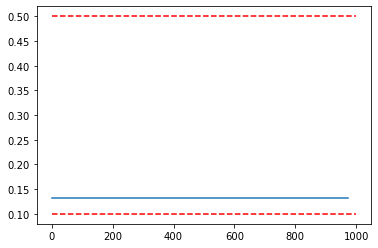

In [210]:
plt.plot(sorted(y_prob[:,1])) # spam
plt.hlines(.5, 0, 1000, colors='r', linestyles='dashed')
plt.hlines(.1, 0, 1000, colors='r', linestyles='dashed')
plt.show()

Testing a mid-point for $C$ and $\gamma$:

In [213]:
svm_clf_prob_reg = SVC(
    random_state=42
    , probability=True
    , C=5e01
    , gamma=5e-01
)

In [214]:
fit_clf(svm_clf_prob_reg)

Elapsed: 1m 39s


In [215]:
y_prob = svm_clf_prob_reg.predict_proba(X_val)

In [216]:
# default
thresh = .5
y_pred = np.where(y_prob[:,1] > thresh, 1, 0)
print_metrics(y_val, y_pred)

          pred_neg  pred_pos
cond_neg       846         0
cond_pos        81        48
acc: 0.9169
tpr: 0.3721
tnr: 1.0000


In [223]:
# low
thresh = .1
y_pred = np.where(y_prob[:,1] > thresh, 1, 0)
print_metrics(y_val, y_pred)

          pred_neg  pred_pos
cond_neg       846         0
cond_pos        70        59
acc: 0.9282
tpr: 0.4574
tnr: 1.0000


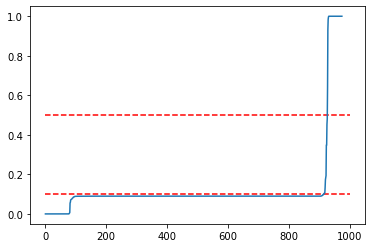

In [224]:
plt.plot(sorted(y_prob[:,1])) # spam
plt.hlines(.5, 0, 1000, colors='r', linestyles='dashed')
plt.hlines(.1, 0, 1000, colors='r', linestyles='dashed')
plt.show()

In [238]:
# gamma=scale (default) means...
n_features = X_train.shape[0]
X_var = np.var(X_train.toarray())
gamma = 1 / (n_features * X_var)
gamma

0.007769843438828635

In [239]:
svm_clf_prob_reg = SVC(
    random_state=42
    , probability=True
    , C=0.7
    , gamma=0.0005
)

In [240]:
fit_clf(svm_clf_prob_reg)

Elapsed: 0m 48s


In [241]:
y_prob = svm_clf_prob_reg.predict_proba(X_val)

In [244]:
# default
thresh = .1
y_pred = np.where(y_prob[:,1] > thresh, 1, 0)
print_metrics(y_val, y_pred)

          pred_neg  pred_pos
cond_neg       822        24
cond_pos        10       119
acc: 0.9651
tpr: 0.9225
tnr: 0.9716


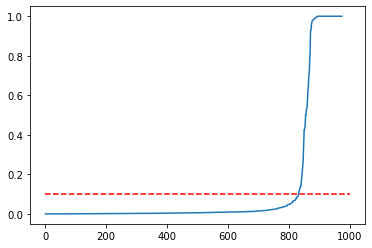

In [245]:
plt.plot(sorted(y_prob[:,1])) # spam
plt.hlines(.1, 0, 1000, colors='r', linestyles='dashed')
plt.show()

---